In [1]:
from pathlib import Path
import pandas as pd
from datetime import timedelta
import datetime
import requests
import yfinance as yf
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
#from xgboost import XGBClassifier
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.metrics import plot_confusion_matrix

In [2]:
#read csv data from IPO Scoop into a dataframe and set the company Symbol as the index
#other columns include industry type, amount of shares in millions, initial offer price, closing on the first day
#current price and returns, and then dropping the 1st day close column
ipo_csv = pd.read_csv('IpoScoop2018+.csv')
#filtered_ipo=ipo_csv.drop(columns=["1st Day Close"])
ipo_csv.set_index('Symbol',inplace=True)

filtered_ipo = ipo_csv
filtered_ipo

,Company,Industry,Offer Date,Shares (millions),Offer Price,1st Day Close,Current Price,Return
Symbol,,,,,,,,
BLTE,"Belite Bio, Inc.",Health Care,4/29/2022,6.0,$6.00,$10.59,$10.59,76.50%
HLVX,"HilleVax, Inc.",Health Care,4/29/2022,11.8,$17.00,$19.09,$19.09,12.29%
OST,"Ostin Technology Group Co., Ltd.",Industrials,4/27/2022,3.4,$4.00,$39.66,$3.70,-7.50%
TNON,"Tenon Medical, Inc.",Health Care,4/27/2022,3.2,$5.00,$22.50,$21.61,332.20%
JCSE,JE Cleantech Holdings Limited,Industrials,4/22/2022,3.8,$4.00,$19.00,$4.35,8.75%
...,...,...,...,...,...,...,...,...
TLRY,Tilray,Health Care,7/19/2018,9.0,$17.00,$22.39,$46.56,173.88%
CCB,Coastal Financial,Financials,7/18/2018,2.9,$14.50,$16.40,$15.47,6.69%
CRNX,Crinetics Pharmaceuticals,Health Care,7/18/2018,6.0,$17.00,$24.51,$25.00,47.06%


<AxesSubplot:ylabel='Industry'>

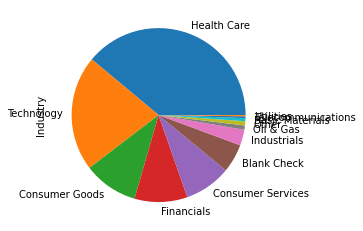

In [3]:
#visualization of different industries
sector_count = filtered_ipo["Industry"].value_counts()
sector_count.plot(kind="pie")

In [4]:
# drop tickers that were discontinued
filtered_ipo["Offer Date"]=pd.to_datetime(filtered_ipo["Offer Date"], infer_datetime_format=True)
filter_ipo = filtered_ipo.drop(['MTAL.U', 'TPGS', 'KVSB', 'STRE.U', 'SCR', 'FWAA', 'HCAQ', 'TBA.U', 'HFEN', 'FSDC', 'ARYA', 'PAND', 'TXAC', 'HECCU', 'CSPR', 'PPD', 'DNK', 'VIE', 'HKIB', 'WSG', 'LVGO', 'PROS', 'MDLA', 'PRVL', 'PRVL', 'PRVL', 'MWK', 'GSX', 'RUHN', 'FHL', 'AVDR', 'THOR', 'OSMT', 'UROV', 'SVMK', 'PRNB', 'CNST'])
filter_ipo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 851 entries, BLTE to DOMO
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Company            851 non-null    object        
 1   Industry           851 non-null    object        
 2   Offer Date         851 non-null    datetime64[ns]
 3   Shares (millions)  851 non-null    float64       
 4   Offer Price        851 non-null    object        
 5   1st Day Close      851 non-null    object        
 6   Current Price      851 non-null    object        
 7   Return             851 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 59.8+ KB


In [5]:
#make copies of the ipo dataframe with times showing 10 days before, 84 days before, and 100 days after 'Offer Date'
ten_days = pd.to_timedelta(10,'days')
three_months = pd.to_timedelta(84,'days')
hundred_days = pd.to_timedelta(100,'days')
filter_ipo['T-10Days'] = filter_ipo['Offer Date']-ten_days
filter_ipo['T-90Days'] = filter_ipo['Offer Date']-three_months
filter_ipo['T+100Days'] = filter_ipo['Offer Date']+hundred_days

In [6]:
#convert to string for yf useage
filter_ipo['T-10Days'] = filter_ipo['T-10Days'].astype(str)
filter_ipo['T-90Days'] = filter_ipo['T-90Days'].astype(str)
filter_ipo['T+100Days'] = filter_ipo['T+100Days'].astype(str)

In [14]:
#for ticker in filter_ipo2.index:
#    data3 = spy_returns_ALL.loc[filter_ipo2.loc[ticker,'T-90Days']:filter_ipo2.loc[ticker,'T-10Days']]# [start: end] dates
#    spy_return = (data3.iloc[-1,-2] - data3.iloc[0,-2])/data3.iloc[0,-2]
#    filter_ipo2.loc[ticker,'SPY 90D Return'] = spy_return
#    print(ticker)
#    data2=yf.download(ticker,filter_ipo2.loc[ticker,'Offer Date'], filter_ipo2.loc[ticker,'T+100Days'],progress=True)
#    stock_return = (data2.iloc[-1,-2] - data2.iloc[0,-2])/data2.iloc[0,-2]
#    filter_ipo2.loc[ticker,'100 day Return'] = stock_return

## Temporarily Disabled to avoid re-download

In [7]:

#make copies of the ipo dataframe with times showing 10 days before, 84 days before, and 100 days after 'Offer Date'
for ticker in filter_ipo.index:
    data=yf.download("SPY",filter_ipo.loc[ticker,'T-90Days'], filter_ipo.loc[ticker,'T-10Days'],progress=True)
    spy_return = (data.iloc[-1,-2] - data.iloc[0,-2])/data.iloc[0,-2]
    filter_ipo.loc[ticker,'SPY 90D Return'] = spy_return
    print(ticker)
    data2=yf.download(ticker,filter_ipo.loc[ticker,'Offer Date'], filter_ipo.loc[ticker,'T+100Days'],progress=True)
    stock_return = (data2.iloc[-1,-2] - data2.iloc[0,-2])/data2.iloc[0,-2]
    filter_ipo.loc[ticker,'100 day Return'] = stock_return

[*********************100%***********************]  1 of 1 completed
BLTE
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
HLVX
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
OST
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
TNON
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
JCSE
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
APLD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
EE
[*********************100%***********************]  1 of 1 completed
[*

IndexError: single positional indexer is out-of-bounds

In [8]:
#checking output
filter_ipo


,Company,Industry,Offer Date,Shares (millions),Offer Price,1st Day Close,Current Price,Return,T-10Days,T-90Days,T+100Days,SPY 90D Return,100 day Return
Symbol,,,,,,,,,,,,,
BLTE,"Belite Bio, Inc.",Health Care,2022-04-29,6.0,$6.00,$10.59,$10.59,76.50%,2022-04-19,2022-02-04,2022-08-07,-0.020881,0.168083
HLVX,"HilleVax, Inc.",Health Care,2022-04-29,11.8,$17.00,$19.09,$19.09,12.29%,2022-04-19,2022-02-04,2022-08-07,-0.020881,0.027763
OST,"Ostin Technology Group Co., Ltd.",Industrials,2022-04-27,3.4,$4.00,$39.66,$3.70,-7.50%,2022-04-17,2022-02-02,2022-08-05,-0.039794,-0.902421
TNON,"Tenon Medical, Inc.",Health Care,2022-04-27,3.2,$5.00,$22.50,$21.61,332.20%,2022-04-17,2022-02-02,2022-08-05,-0.039794,0.299111
JCSE,JE Cleantech Holdings Limited,Industrials,2022-04-22,3.8,$4.00,$19.00,$4.35,8.75%,2022-04-12,2022-01-28,2022-07-31,-0.001501,-0.754211
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TLRY,Tilray,Health Care,2018-07-19,9.0,$17.00,$22.39,$46.56,173.88%,2018-07-09,2018-04-26,2018-10-27,NaN,NaN
CCB,Coastal Financial,Financials,2018-07-18,2.9,$14.50,$16.40,$15.47,6.69%,2018-07-08,2018-04-25,2018-10-26,NaN,NaN
CRNX,Crinetics Pharmaceuticals,Health Care,2018-07-18,6.0,$17.00,$24.51,$25.00,47.06%,2018-07-08,2018-04-25,2018-10-26,NaN,NaN


In [9]:
# Saving dataframe to csv to avoid 25min wait re-downloading date when restarting kernel

filter_ipo.to_csv('ipo_downloaded_data.csv')

y_scrape_ipo = pd.read_csv()

In [41]:
#Reading the downloaded data from CSV
filter_ipo = pd.read_csv('ipo_downloaded_data.csv')
filter_ipo.set_index('Symbol',inplace=True)
filter_ipo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 851 entries, BLTE to DOMO
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Company            851 non-null    object 
 1   Industry           851 non-null    object 
 2   Offer Date         851 non-null    object 
 3   Shares (millions)  851 non-null    float64
 4   Offer Price        851 non-null    object 
 5   1st Day Close      851 non-null    object 
 6   Current Price      851 non-null    object 
 7   Return             851 non-null    object 
 8   T-10Days           851 non-null    object 
 9   T-90Days           851 non-null    object 
 10  T+100Days          851 non-null    object 
 11  SPY 90D Return     247 non-null    float64
 12  100 day Return     246 non-null    float64
dtypes: float64(3), object(10)
memory usage: 93.1+ KB


In [42]:
filter_ipo['Offer Date'] =  pd.to_datetime(filter_ipo['Offer Date'], format='%Y-%m-%d')
filter_ipo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 851 entries, BLTE to DOMO
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Company            851 non-null    object        
 1   Industry           851 non-null    object        
 2   Offer Date         851 non-null    datetime64[ns]
 3   Shares (millions)  851 non-null    float64       
 4   Offer Price        851 non-null    object        
 5   1st Day Close      851 non-null    object        
 6   Current Price      851 non-null    object        
 7   Return             851 non-null    object        
 8   T-10Days           851 non-null    object        
 9   T-90Days           851 non-null    object        
 10  T+100Days          851 non-null    object        
 11  SPY 90D Return     247 non-null    float64       
 12  100 day Return     246 non-null    float64       
dtypes: datetime64[ns](1), float64(3), object(9)
memory usage: 93.1+ KB

In [43]:
# Encode Offer Date to week of year
for ticker in filter_ipo.index:
    filter_ipo.loc[ticker,'Offer Date'] = filter_ipo.loc[ticker,'Offer Date'].isocalendar()[1]
    

In [44]:
# Create binary encoded column for whether or not stock saw positive gains after 100 days
returns_bin = []
for pct in filter_ipo['100 day Return']:
    if pct >= 0:
        returns_bin.append(1)
    else:
        returns_bin.append(0)
        
filter_ipo['100D Y/N'] = returns_bin

#Encoding "Industry" Column
le = LabelEncoder()
le.fit(filter_ipo["Industry"])
filter_ipo["Industry"] = le.transform(filter_ipo["Industry"])

# Drop unecessary date columns
#filter_ipo.drop(columns=['T-10Days','T-90Days','T+100Days'], inplace=True)

In [45]:
# Use glob to create categorized lists of Yahoo Finance CSV's for parsing
bs_list = glob.glob("*_annual_balance-sheet.csv")
cf_list = glob.glob("*_annual_cash-flow.csv")
af_list = glob.glob("*_annual_financials.csv")
list_of_lists = [bs_list,cf_list,af_list]

In [48]:
# Clean and organize CSV
def step_1(frame):
    frame_df = frame.set_index('name')
    
    # Delete TTM column as this data may be more recent than date of IPO
    if 'ttm' in frame_df.columns: 
        frame_df.drop(columns = 'ttm',inplace=True)
    else:
        pass
    
    # Keep only latest annual financial data from year prior to IPO
    if len(frame_df) == 0:
        pass
    else:
        frame_df = frame_df.iloc[:,0]
    
    # Fill NaN's
        frame_df = pd.DataFrame(frame_df.fillna(0))
    
    # Transpose DataFrame
        frame_df = frame_df.T
    
    # Standardize index
        frame_df = frame_df.reset_index()
    
    #Remove '\t...' from column names
        frame_df.columns = frame_df.columns.str.strip()
    
        return frame_df

In [49]:
#Create dataframe for CSV per respective category
def step_2(list):
    df = pd.DataFrame()
    
    # Loop through each list of YF Financials and clean CSV
    for file in list:
        
        # Read in CSV
        path = Path(file)
        csv = pd.read_csv(path, engine='python')
        
        # Clean CSV using step_1 function
        step = step_1(csv)
        
        # Add data from csv to df
        df = pd.concat([df,step], axis = 0)
        
        # Fill NaNs
        df = df.fillna(0)
        
        # Remove "\t" from column names
        df.columns = df.columns.str.strip()
        
        # Reset index
        df.reset_index(drop=True, inplace=True)
        
        # Drop useless column
        #df.drop(columns='index',inplace=True)
    
    # Loop through columns and drop columns that have 0 for more than 20% of the data therein
    for column in df.columns[1:]:
        zeros = (df[column]==0).sum()
        if zeros >= 0.8*len(df.index):
            df.drop(columns = column, inplace = True)
        else:
            pass
    
    return df

In [50]:
# Create dataframe concatenated from respective categorical dataframes
def step_3(list):
    df = pd.DataFrame()
    tickers = []
    
    # Loop through each list of respective YF CSVs
    for l in list_of_lists:
        
        #Clean and concatenate CSV based on category
        frame = step_2(l)
        df = pd.concat([df,frame],axis=1)
    
    # Drop random NaN row?
    print(len(df))
    #df = df.dropna()
    
    #Clean and update index for syntax
    for name in bs_list:
        tickers.append(name[:4])

    df.index = tickers
    
    for x in df.index:
        if x[3] == '_':
             df.rename(index={x:x[:3]},inplace=True)
        elif x[2] == '_':
            df.rename(index={x:x[:2]},inplace=True)
        elif x[1] == '_':
            df.rename(index={x:x[:1]},inplace=True)
        else:
            pass
    
    return df

In [51]:
#Running Functions and Compiling DFs
bz_df = step_3(list_of_lists)
bz_ipo_df = pd.concat([bz_df, filter_ipo],axis=1)
bz_ipo_df.drop(columns='Return', inplace=True)
bz_ipo_df = bz_ipo_df.dropna()
#bz_ipo_df.set_index('Industry',inplace=True)
#bz_ipo_df = bz_ipo_df.drop(columns='Symbol')
bz_ipo_df

0


,Company,Industry,Offer Date,Shares (millions),Offer Price,1st Day Close,Current Price,T-10Days,T-90Days,T+100Days,SPY 90D Return,100 day Return,100D Y/N
Symbol,,,,,,,,,,,,,
BLTE,"Belite Bio, Inc.",5,17,6.0,$6.00,$10.59,$10.59,2022-04-19,2022-02-04,2022-08-07,-0.020881,0.168083,1
HLVX,"HilleVax, Inc.",5,17,11.8,$17.00,$19.09,$19.09,2022-04-19,2022-02-04,2022-08-07,-0.020881,0.027763,1
OST,"Ostin Technology Group Co., Ltd.",6,17,3.4,$4.00,$39.66,$3.70,2022-04-17,2022-02-02,2022-08-05,-0.039794,-0.902421,0
TNON,"Tenon Medical, Inc.",5,17,3.2,$5.00,$22.50,$21.61,2022-04-17,2022-02-02,2022-08-05,-0.039794,0.299111,1
JCSE,JE Cleantech Holdings Limited,6,16,3.8,$4.00,$19.00,$4.35,2022-04-12,2022-01-28,2022-07-31,-0.001501,-0.754211,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
MF,Missfresh Limited,3,25,21.0,$13.00,$9.66,$0.52,2021-06-15,2021-04-02,2021-10-03,0.046511,-0.567288,0
MCW,"Mister Car Wash, Inc.",3,25,37.5,$15.00,$20.30,$14.40,2021-06-15,2021-04-02,2021-10-03,0.046511,-0.057143,0
BON,Bon Natural Life Limited,3,25,2.2,$5.00,$7.20,$5.16,2021-06-14,2021-04-01,2021-10-02,0.059160,0.081944,1


In [52]:
bz_ipo_df.loc[:,'Industry'] = bz_ipo_df.loc[:,'Industry'].astype(str)
bz_ipo_df.loc[:,'100D Y/N'] = bz_ipo_df.loc[:,'100D Y/N'].astype(str)

In [211]:
for column in bz_ipo_df.columns:
    bz_ipo_df.loc[:,column] = bz_ipo_df.loc[:,column].astype(str)
    bz_ipo_df.loc[:,column] = bz_ipo_df.loc[:,column].str.replace('$','')
    bz_ipo_df.loc[:,column] = bz_ipo_df.loc[:,column].str.replace(',','')
    #.astype(float)

/var/folders/2b/7l_c8d254hn15vrfcsl1sr_r0000gn/T/ipykernel_5435/3963379596.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  bz_ipo_df.loc[:,column] = bz_ipo_df.loc[:,column].str.replace('$','')


In [212]:
bz_ipo_df['100D Y/N'].value_counts()

0    178
1     68
Name: 100D Y/N, dtype: int64

In [213]:
bz_ipo_df

,Company,Industry,Offer Date,Shares (millions),Offer Price,1st Day Close,Current Price,T-10Days,T-90Days,T+100Days,SPY 90D Return,100 day Return,100D Y/N
Symbol,,,,,,,,,,,,,
BLTE,Belite Bio Inc.,5,17,6.0,6.00,10.59,10.59,2022-04-19,2022-02-04,2022-08-07,-0.0208812341177367,0.1680830696245279,1
HLVX,HilleVax Inc.,5,17,11.8,17.00,19.09,19.09,2022-04-19,2022-02-04,2022-08-07,-0.0208812341177367,0.0277632625672692,1
OST,Ostin Technology Group Co. Ltd.,6,17,3.4,4.00,39.66,3.70,2022-04-17,2022-02-02,2022-08-05,-0.0397943592088691,-0.9024205773966586,0
TNON,Tenon Medical Inc.,5,17,3.2,5.00,22.50,21.61,2022-04-17,2022-02-02,2022-08-05,-0.0397943592088691,0.299111090766059,1
JCSE,JE Cleantech Holdings Limited,6,16,3.8,4.00,19.00,4.35,2022-04-12,2022-01-28,2022-07-31,-0.0015009384241898,-0.7542105223003187,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
MF,Missfresh Limited,3,25,21.0,13.00,9.66,0.52,2021-06-15,2021-04-02,2021-10-03,0.046510544978206,-0.5672877956143617,0
MCW,Mister Car Wash Inc.,3,25,37.5,15.00,20.30,14.40,2021-06-15,2021-04-02,2021-10-03,0.046510544978206,-0.0571428517738249,0
BON,Bon Natural Life Limited,3,25,2.2,5.00,7.20,5.16,2021-06-14,2021-04-01,2021-10-02,0.0591598082379868,0.0819444678079941,1


In [214]:
# Split and scale data
#bz_ipo_df.drop(bz_ipo_df.columns[['100 day Return', 'Company']], axis = 1, inplace = True)
bz_ipo_df1=bz_ipo_df.drop(columns=['100 day Return', 'Company', 'T-10Days' , 'T-90Days' , 'T+100Days' ])

In [215]:
bz_ipo_df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246 entries, BLTE to CFLT
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Industry           246 non-null    object
 1   Offer Date         246 non-null    object
 2   Shares (millions)  246 non-null    object
 3   Offer Price        246 non-null    object
 4   1st Day Close      246 non-null    object
 5   Current Price      246 non-null    object
 6   SPY 90D Return     246 non-null    object
 7   100D Y/N           246 non-null    object
dtypes: object(8)
memory usage: 25.4+ KB


In [216]:
# Convert df objects to int or float
bz_ipo_df1["Industry"] = pd.to_numeric(bz_ipo_df1["Industry"])
bz_ipo_df1["Offer Date"] = pd.to_numeric(bz_ipo_df1["Offer Date"])
bz_ipo_df1["Shares (millions)"] = pd.to_numeric(bz_ipo_df1["Shares (millions)"])
bz_ipo_df1["Offer Price"] = pd.to_numeric(bz_ipo_df1["Offer Price"])
bz_ipo_df1["Current Price"] = pd.to_numeric(bz_ipo_df1["Current Price"])
bz_ipo_df1["SPY 90D Return"] = pd.to_numeric(bz_ipo_df1["SPY 90D Return"])
bz_ipo_df1["100D Y/N"] = pd.to_numeric(bz_ipo_df1["100D Y/N"])
bz_ipo_df1["1st Day Close"] = pd.to_numeric(bz_ipo_df1["1st Day Close"])
bz_ipo_df1["100D Y/N"] = pd.to_numeric(bz_ipo_df1["100D Y/N"])
bz_ipo_df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246 entries, BLTE to CFLT
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Industry           246 non-null    int64  
 1   Offer Date         246 non-null    int64  
 2   Shares (millions)  246 non-null    float64
 3   Offer Price        246 non-null    float64
 4   1st Day Close      246 non-null    float64
 5   Current Price      246 non-null    float64
 6   SPY 90D Return     246 non-null    float64
 7   100D Y/N           246 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.4+ KB


In [217]:
# Add more Features
# Computing 1st Day return
bz_ipo_df1['1st Day Close Return'] = (bz_ipo_df1['1st Day Close']-bz_ipo_df1['Offer Price'])/bz_ipo_df1['Offer Price']

#Computing Market Cap
bz_ipo_df1['Market Cap'] = (bz_ipo_df1['Offer Price'] * bz_ipo_df1['Shares (millions)'])* 1000000
bz_ipo_df1['Shares (millions)'] = bz_ipo_df1['Shares (millions)'] * 1000000
bz_ipo_df1

,Industry,Offer Date,Shares (millions),Offer Price,1st Day Close,Current Price,SPY 90D Return,100D Y/N,1st Day Close Return,Market Cap
Symbol,,,,,,,,,,
BLTE,5,17,6000000.0,6.0,10.59,10.59,-0.020881,1,0.765000,36000000.0
HLVX,5,17,11800000.0,17.0,19.09,19.09,-0.020881,1,0.122941,200600000.0
OST,6,17,3400000.0,4.0,39.66,3.70,-0.039794,0,8.915000,13600000.0
TNON,5,17,3200000.0,5.0,22.50,21.61,-0.039794,1,3.500000,16000000.0
JCSE,6,16,3800000.0,4.0,19.00,4.35,-0.001501,0,3.750000,15200000.0
...,...,...,...,...,...,...,...,...,...,...
MF,3,25,21000000.0,13.0,9.66,0.52,0.046511,0,-0.256923,273000000.0
MCW,3,25,37500000.0,15.0,20.30,14.40,0.046511,0,0.353333,562500000.0
BON,3,25,2200000.0,5.0,7.20,5.16,0.059160,1,0.440000,11000000.0


In [218]:
# Rearrange Columns in dataframe
bz_ipo_df1 = bz_ipo_df1[["Industry", "Offer Date", "Shares (millions)","Offer Price" ,"1st Day Close" ,"Current Price" ,"SPY 90D Return" ,"1st Day Close Return", "Market Cap", "100D Y/N"	  ]]
#bz_ipo_df1=bz_ipo_df.drop(columns=["1st Day Close"])
bz_ipo_df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246 entries, BLTE to CFLT
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Industry              246 non-null    int64  
 1   Offer Date            246 non-null    int64  
 2   Shares (millions)     246 non-null    float64
 3   Offer Price           246 non-null    float64
 4   1st Day Close         246 non-null    float64
 5   Current Price         246 non-null    float64
 6   SPY 90D Return        246 non-null    float64
 7   1st Day Close Return  246 non-null    float64
 8   Market Cap            246 non-null    float64
 9   100D Y/N              246 non-null    int64  
dtypes: float64(7), int64(3)
memory usage: 29.2+ KB


In [219]:
# Split Train and Test
X = bz_ipo_df1.iloc[:, 0:-1]
y = bz_ipo_df1.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=69)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [220]:
# Use RandomOverSampler to balance data
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [221]:
# Create and train LR model
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=1)
classifier.fit(X_train, y_train)

# Execute LR predictions
predictions = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
results


,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,1
...,...,...
57,0,0
58,1,1
59,0,0
60,1,1


[[42  1]
 [ 8 11]]


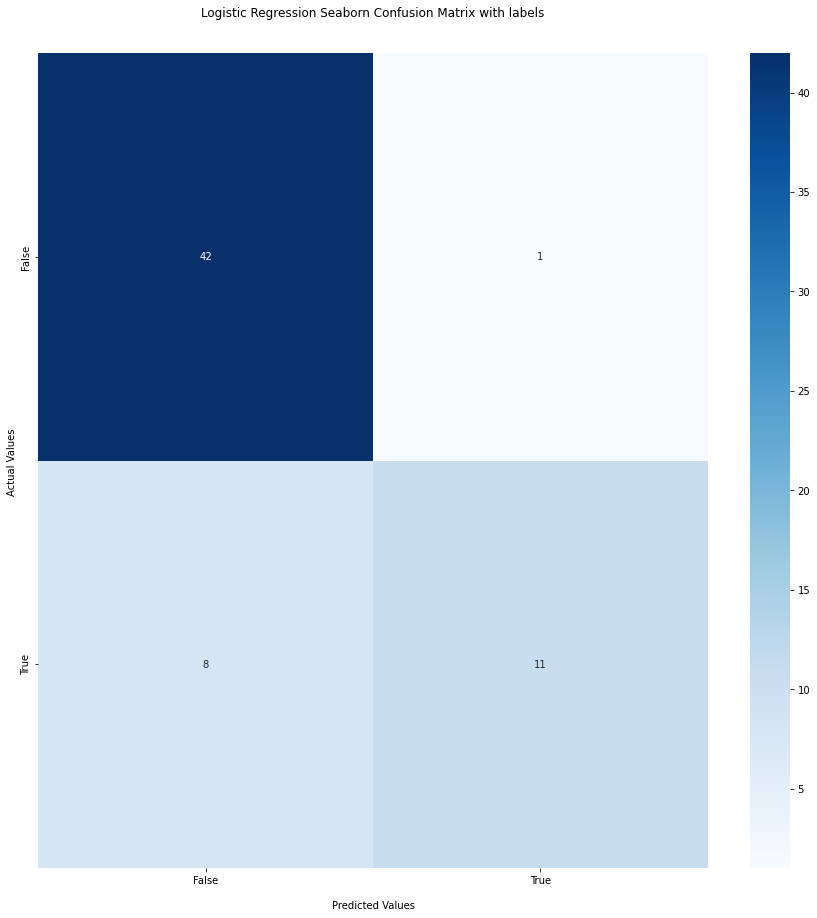

In [222]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix
cf_matrix= confusion_matrix(y_test, predictions)
print(cf_matrix)
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Logistic Regression Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
#export to image
plt.savefig("pics/logistic_regression.png",bbox_inches="tight",dpi=220)
# Display the visualization of the Confusion Matrix.
plt.show()

In [223]:
# Create a classification report
target_names = ["0.0", "1.0"]
print(classification_report(y_test, predictions, target_names=target_names))

              precision    recall  f1-score   support

         0.0       0.84      0.98      0.90        43
         1.0       0.92      0.58      0.71        19

    accuracy                           0.85        62
   macro avg       0.88      0.78      0.81        62
weighted avg       0.86      0.85      0.84        62



## AdaBoost 

In [224]:
#AdaBoost model     
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
from sklearn import datasets


In [225]:
# Create and train Adaboost model
adamodel = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
adamodel.fit(X_train, y_train)


AdaBoostClassifier(learning_rate=1)

In [226]:
# Execute LR predictions
predictions_ada = adamodel.predict(X_test)
results_ada = pd.DataFrame({"Prediction": predictions_ada, "Actual": y_test}).reset_index(drop=True)
results_ada


,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,1
...,...,...
57,0,0
58,1,1
59,0,0
60,0,1


[[35  8]
 [10  9]]


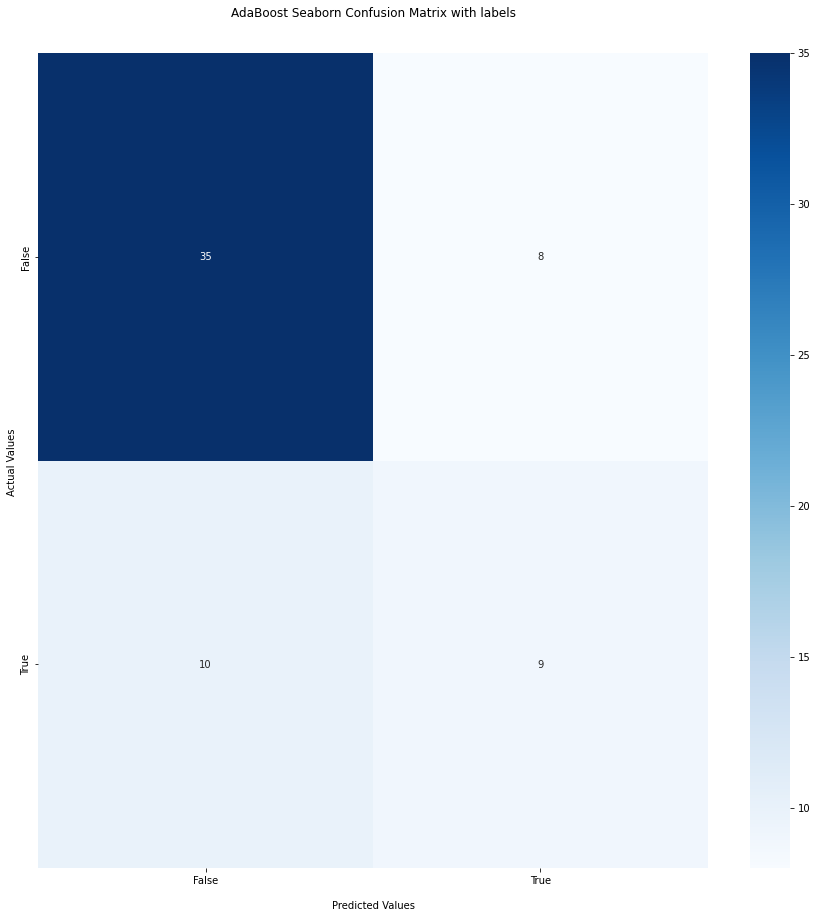

In [227]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix
cf_matrix_ada= confusion_matrix(y_test, predictions_ada)
print(cf_matrix_ada)
import seaborn as sns

ax = sns.heatmap(cf_matrix_ada, annot=True, cmap='Blues')

ax.set_title('AdaBoost Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
#export to image
plt.savefig("pics/adaboost.png",bbox_inches="tight",dpi=220)

# Display the visualization of the Confusion Matrix.
plt.show()

In [228]:
# Create a classification report
target_names = ["0.0", "1.0"]
print(classification_report(y_test, predictions_ada, target_names=target_names))

              precision    recall  f1-score   support

         0.0       0.78      0.81      0.80        43
         1.0       0.53      0.47      0.50        19

    accuracy                           0.71        62
   macro avg       0.65      0.64      0.65        62
weighted avg       0.70      0.71      0.70        62



## XGBoost

In [229]:
# Imports
import xgboost as xgb
from sklearn.metrics import mean_squared_error


In [230]:
#splitting of the Features and Output Variable

X, y = bz_ipo_df1.iloc[:,:-1],bz_ipo_df1.iloc[:,-1]

In [231]:
# convert the dataset into an optimized data structure called Dmatrix that XGBoost supports and gives it acclaimed performance and efficiency gains. 
data_dmatrix = xgb.DMatrix(X,y)


In [232]:
#Splitting Train and test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test_xg = train_test_split(X, y, test_size=0.25, random_state=69)


In [233]:
#Visualization Params
#xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                #max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg = xgb.XGBClassifier()



In [234]:
#Fit the model
xg_reg.fit(X_train,y_train)

#preds_xg = xg_reg.predict(X_test)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [235]:
# Execute LR predictions
preds_xg = xg_reg.predict(X_test)



In [236]:

results_xg = pd.DataFrame({"Prediction": preds_xg, "Actual": y_test_xg}).reset_index(drop=True)
results_xg

,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,1
...,...,...
57,0,0
58,1,1
59,0,0
60,0,1


In [237]:
rmse = np.sqrt(mean_squared_error(y_test_xg, preds_xg))
print("RMSE: %f" % (rmse))

RMSE: 0.457905


In [238]:
#k-fold Cross Validation using XGBoost. In order to build more robust models, it is common to do a k-fold cross validation 
# where all the entries in the original training dataset are used for both training as well as validation. 
# Also, each entry is used for validation just once.
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=69)

In [239]:
#Visualize Boosting Trees and Feature Importance
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

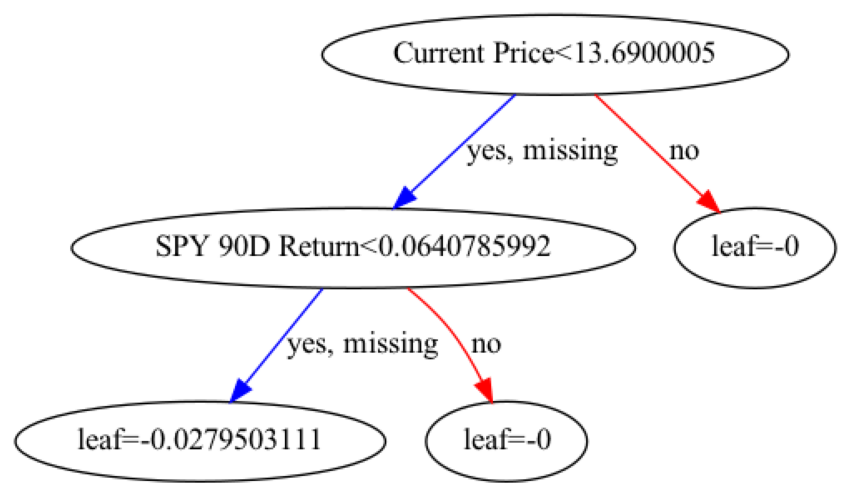

In [240]:
# Plotting the first tree with the matplotlib library
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

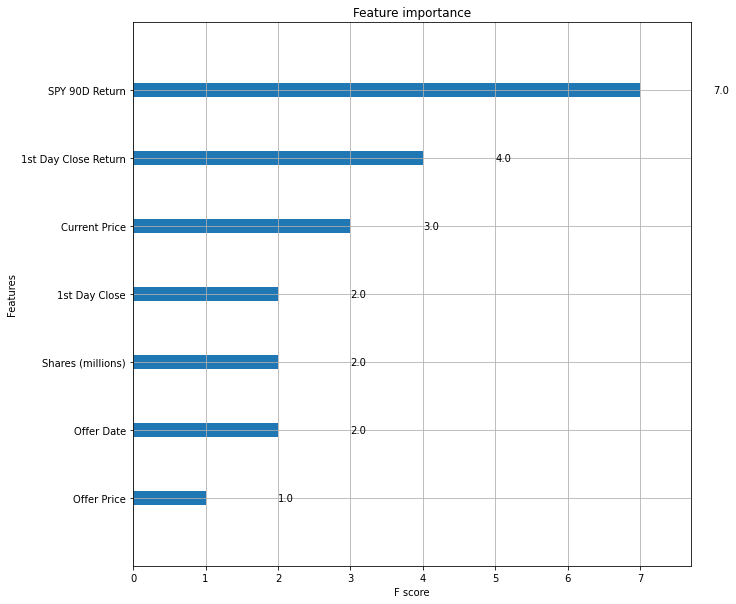

In [241]:
# Visualizing the feature importance result as a bar graph
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [15, 15]
plt.show()

In [242]:
# Confusion matrix
cf_matrix_xg= confusion_matrix(y_test_xg, preds_xg)
print(cf_matrix_xg)

[[38  5]
 [ 8 11]]


In [243]:
# Create a classification report
target_names = ["0.0", "1.0"]
print(classification_report(y_test_xg, preds_xg, target_names=target_names))

              precision    recall  f1-score   support

         0.0       0.83      0.88      0.85        43
         1.0       0.69      0.58      0.63        19

    accuracy                           0.79        62
   macro avg       0.76      0.73      0.74        62
weighted avg       0.78      0.79      0.78        62



[[38  5]
 [ 8 11]]


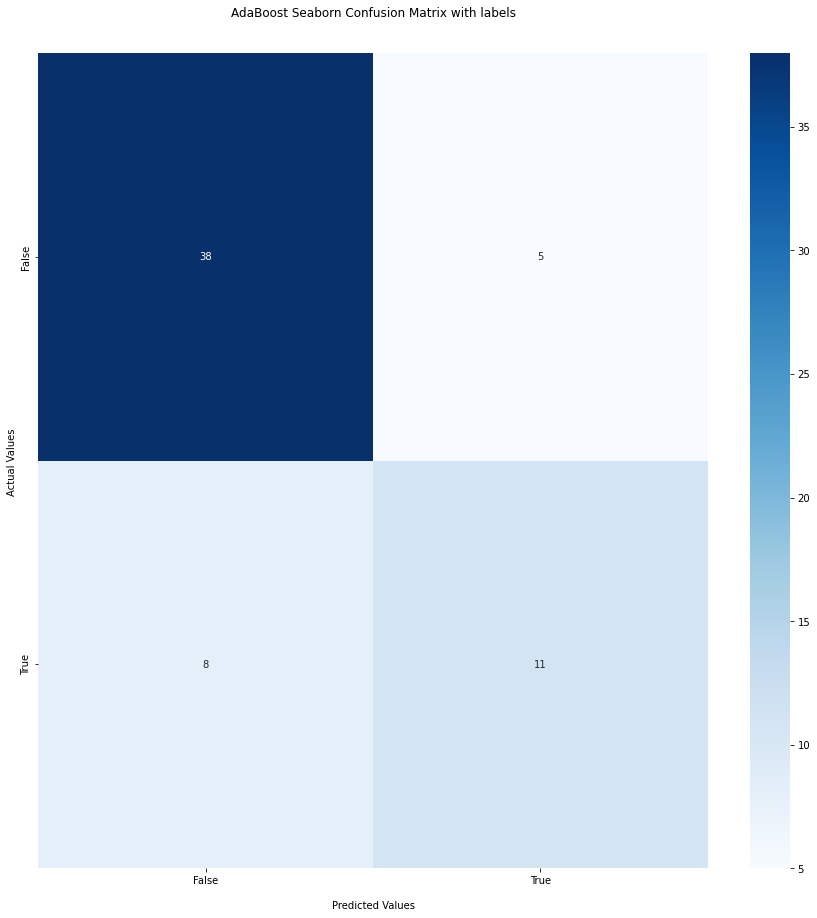

In [244]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix
cf_matrix_xg= confusion_matrix(y_test_xg, preds_xg)
print(cf_matrix_xg)
import seaborn as sns

ax = sns.heatmap(cf_matrix_xg, annot=True, cmap='Blues')

ax.set_title('AdaBoost Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
#export to image
plt.savefig("pics/xgboost.png",dpi=220)

# Display the visualization of the Confusion Matrix.
plt.show()